# Simulation 1: ILP vs. SG

TJ Kim
8/7/20

Run the first simulation with the following considerations.

- 5 Servers, 5 TS, 6 Users
- Use ONE-mobility
- Servers have limited resources, links have high resources
- All jobs are 5 TS long
- We share the same users and jobs

Resources: Limited
- All jobs are run with standard Quantity
- All servers are level 2
- Cores have been tweaked to [3,5] at all servers

In [1]:
from IPython.core.debugger import set_trace

# Import Generic Classes
import numpy as np
import copy
import pickle
import random

# Import All Custom Classes
import os, sys
sys.path.append(os.path.pardir+"/classes")
sys.path.append(os.path.pardir+"/solvers")
sys.path.append(os.path.pardir+"/one_mobility")
sys.path.append(os.path.curdir+"/sim_store/sim1")


from Server import *
from User import *
from Link import *
from Job import *
from Migration_Plans import *
from Cost_Recordings import *

from sim1_setting import *

# Import Solver Classes
from Optim_PlanGenerator import *
from SeqGreedy_PlanGenerator import *
from Myopic_PlanGenerator import *
from Naive_PlanGenerator import *

### Run 10 Trials

Iteratively run trials x 10 and store the cost data for each the ILP and the SG models.

In [11]:
num_trials = 1
# ILP_cost_stores = []
# SG_cost_stores = []

for i in range(num_trials):
    
    print("Trial Number:",i)
    
    # Make Users
    users, servers, links, jobs, sim_param = simulation_setting()
    
    # Make ILP and Optim Prob
    print("Generating Optim_Prob...")
    optim_prob = Optim_PlanGenerator(users, servers, links, jobs, sim_param)
    print("Finished_Generating_prob...")
    
    # Solve the problem and get the migration plan 
    optim_prob.prob.solve()
    print("Status:", constants.LpStatus[optim_prob.prob.status])
    ILP_mig_plan = Migration_Plans(users, jobs, sim_param) 
    ILP_mig_plan.from_ILP(optim_prob)
    
    ILP_cost_stores += [Cost_Recordings(ILP_mig_plan)]
    
    
    # Make SG Prob
    SG_prob = SeqGreedy_PlanGenerator(users, servers, links, jobs, sim_param)
    SG_plan = Migration_Plans(users,jobs,sim_param)
    SG_plan.from_seq_greedy(SG_prob)
    
    SG_cost_stores += [Cost_Recordings(SG_plan)]

Trial Number: 0
Generating Optim_Prob...
Finished_Generating_prob...
Status: Optimal


### Plot the average or total cost and subcost

8 bars in total one for ILP one for SG
- Total Cost
- Placement cost
- Bandwidth Cost
- User Experience Cost

In [14]:
num_trials = len(ILP_cost_stores)

# Log the costs of interest
ILP_total_sum = np.zeros(num_trials)
ILP_placement_sum = np.zeros(num_trials)
ILP_bw_sum = np.zeros(num_trials)
ILP_UE_sum = np.zeros(num_trials)

SG_total_sum = np.zeros(num_trials)
SG_placement_sum = np.zeros(num_trials)
SG_bw_sum = np.zeros(num_trials)
SG_UE_sum = np.zeros(num_trials)

for i in range(num_trials):
    ILP_total_sum[i] += ILP_cost_stores[i].all_cost_cumulative["total_cost"][-1]
    ILP_placement_sum[i] += ILP_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
    ILP_bw_sum[i] += ILP_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
    ILP_bw_sum[i] += ILP_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
    ILP_UE_sum[i] += ILP_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
    ILP_UE_sum[i] += ILP_cost_stores[i].all_cost_cumulative["latency_cost"][-1]
    
    SG_total_sum[i] += SG_cost_stores[i].all_cost_cumulative["total_cost"][-1]
    SG_placement_sum[i] += SG_cost_stores[i].all_cost_cumulative["placement_cost"][-1]
    SG_bw_sum[i] += SG_cost_stores[i].all_cost_cumulative["srv_bw_cost"][-1]
    SG_bw_sum[i] += SG_cost_stores[i].all_cost_cumulative["mig_bw_cost"][-1]
    SG_UE_sum[i] += SG_cost_stores[i].all_cost_cumulative["thruput_cost"][-1]
    SG_UE_sum[i] += SG_cost_stores[i].all_cost_cumulative["latency_cost"][-1]



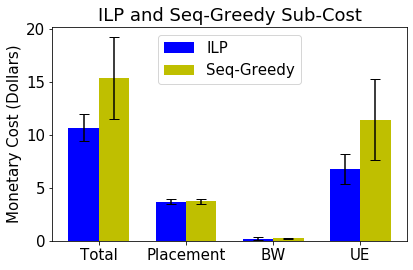

In [15]:
# Plot the plot
import matplotlib
import matplotlib.pyplot as plt

# Set Font Size Limitations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

# Set Labels
labels = ['Total', 'Placement', 'BW', 'UE']

# Obtain Values to Plot
ILP_means = [np.mean(ILP_total_sum), np.mean(ILP_placement_sum), np.mean(ILP_bw_sum), np.mean(ILP_UE_sum)]
SG_means = [np.mean(SG_total_sum), np.mean(SG_placement_sum), np.mean(SG_bw_sum), np.mean(SG_UE_sum)]

ILP_vars = [np.std(ILP_total_sum), np.std(ILP_placement_sum), np.std(ILP_bw_sum), np.std(ILP_UE_sum)]
SG_vars = [np.std(SG_total_sum), np.std(SG_placement_sum), np.std(SG_bw_sum), np.std(SG_UE_sum)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x = x - width/2, height =  ILP_means, yerr = ILP_vars,
                capsize = 5, width = width, label='ILP', color='b')
rects2 = ax.bar(x = x + width/2, height = SG_means, yerr = SG_vars, 
                capsize = 5, width = width, label='Seq-Greedy', color = 'y')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Monetary Cost (Dollars)')
ax.set_title('ILP and Seq-Greedy Sub-Cost')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Set Y axis to zero
plt.ylim(0,)

fig.tight_layout()

plt.show()

### Pickle Result for Reproduction

In [16]:
import pickle

cost_stores_dic = {}
cost_stores_dic["SG"] = SG_cost_stores
cost_stores_dic["ILP"] = ILP_cost_stores

pickle.dump(cost_stores_dic, open(os.path.curdir + "/sim_store/sim1/cost_store.p", "wb" ) )

